# ResNet残差神经网络

## 函数类
对于特定一类神经网络架构$\mathcal{F}$,包括学习率和其他超参数。  
现在假设$f^*$是我们真正想要找到的函数，如果是$f^* \in \mathcal{F}$，那我们可以轻而易举的训练得到它，但通常我们不会那么幸运。
相反，我们将尝试找到一个函数$f^*_\mathcal{F}$，这是我们在$\mathcal{F}$中的最佳选择。
例如，给定一个具有$\mathbf{X}$特性和$\mathbf{y}$标签的数据集，我们可以尝试通过解决以下优化问题来找到它：

$$f^*_\mathcal{F} := \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.$$

对于非嵌套函数（non-nested function）类，较复杂的函数类并不总是向“真”函数$f^*$靠拢（复杂度由$\mathcal{F}_1$向$\mathcal{F}_6$递增）。在图的左边，虽然$\mathcal{F}_3$比$\mathcal{F}_1$更接近$f^*$，但$\mathcal{F}_6$却离的更远了。  
相反对于右侧的嵌套函数（nested function）类$\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$，我们可以避免上述问题。  
![对于非嵌套函数类，较复杂（由较大区域表示）的函数类不能保证更接近“真”函数（ $f^*$ ）。这种现象在嵌套函数类中不会发生。](./img/functionclasses.svg)

## 残差块

对于神经网络局部，原始输入记$x$，期望的理想函数为$f(x)$。  
左侧块需要直接拟合$f(x)$，右侧的块只需要拟合$f(x) - x$。残差映射才现实中更容易优化。
![一个正常块（左图）和一个残差块（右图）。](./img/residual-block.svg)

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

ResNet沿用了VGG完整的$3\times 3$卷积层设计。
残差块里首先有2个有相同输出通道数的$3\times 3$卷积层。
每个卷积层后接一个批量规范化层和ReLU激活函数。  

然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。
这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。

如果想改变通道数，就需要引入一个额外的$1\times 1$卷积层来将输入变换成需要的形状后再做相加运算。
残差块的实现如下：

In [2]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, 
                use_1x1conv = False, strides = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, 
                               kernel_size = 3, padding = 1, stride = strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 
                               kernel_size = 3, padding = 1)

        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, 
                                   kernel_size = 1, stride = strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)  # 修复：在加法后添加ReLU

![包含以及不包含 $1 \times 1$ 卷积层的残差块。](./img/resnet-block.svg)
:label:`fig_resnet_block`

In [3]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [4]:
# 也可以增加输出通道，减半输出高宽--使用1x1的卷积
blk = Residual(3, 3, use_1x1conv= True, strides=2)
blk(X).shape

torch.Size([4, 3, 3, 3])

## 构建ResNet模型

ResNet的前两层跟之前介绍的GoogLeNet中的一样：  
在输出通道数为64、步幅为2的$7 \times 7$卷积层后，接步幅为2的$3 \times 3$的最大汇聚层。
不同之处在于ResNet每个卷积层后增加了批量规范化层。

In [5]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                nn.BatchNorm2d(64), nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
# 残差块由于b1第一层使用了最大池化层，所以这里的高宽无需减半
def resnet_block(input_channels, num_channels, num_residuals,
               first_block=False):
    blk = []
    for i in range(num_residuals):  # 修复：使用num_residuals
        if i == 0 and not first_block:  # 非首个块组需要下采样
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:  # 其他情况保持尺寸
            blk.append(Residual(num_channels, num_channels))
    return blk

In [7]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))    # 输入64->输出128
b4 = nn.Sequential(*resnet_block(128, 256, 2))   # 输入128->输出256
b5 = nn.Sequential(*resnet_block(256, 512, 2))   # 输入256->输出512

In [8]:
## 最后加入全局平均池化、全连接输出
net = nn.Sequential(b1, b2, b3, b4, b5,
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten(), nn.Linear(512, 10))

每个模块有4个卷积层（不包括恒等映射的$1\times 1$卷积层）。
加上第一个$7\times 7$卷积层和最后一个全连接层，共有18层。
因此，这种模型通常被称为ResNet-18。
通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。
虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。
 :numref:`fig_resnet18`描述了完整的ResNet-18。

![ResNet-18 架构](./img/resnet18.svg)
:label:`fig_resnet18`

在训练ResNet之前，让我们[**观察一下ResNet中不同模块的输入形状是如何变化的**]。
在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。


In [9]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## [模型训练]

loss 0.014, train acc 0.996, test acc 0.918
2675.9 examples/sec on cuda:0


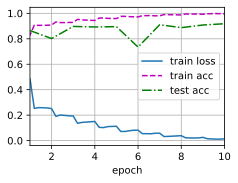

In [10]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

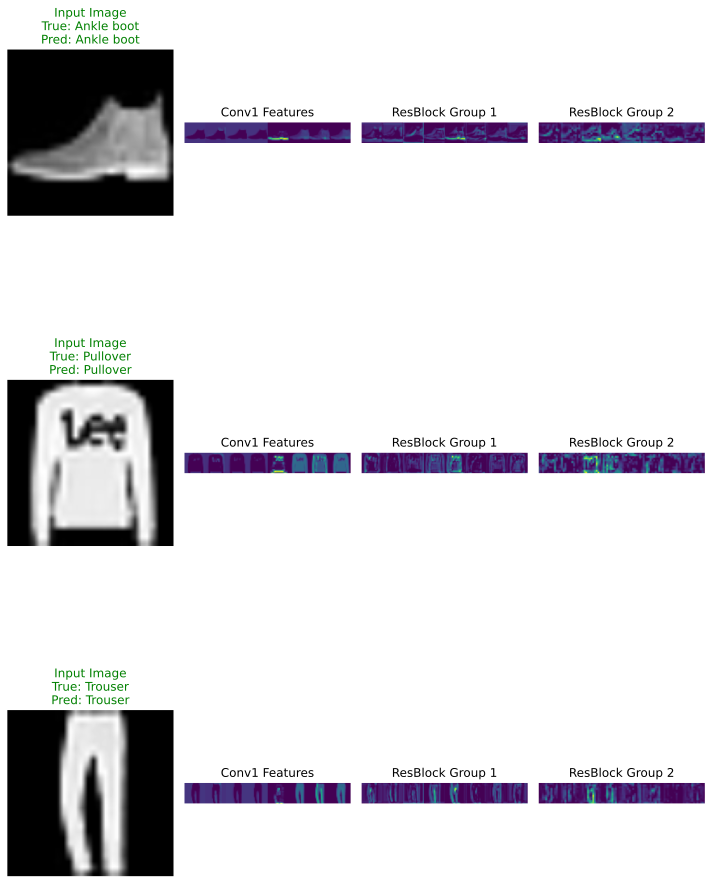

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# 显示ResNet分类结果和特征可视化（无概率图版本）
def visualize_resnet_features(net, test_iter, class_names, n=3):
    """
    可视化ResNet的分类结果和内部特征（无概率图）
    
    参数:
    net - ResNet模型
    test_iter - 测试数据迭代器
    class_names - 类别名称列表
    n - 要显示的样本数量
    """
    # 获取一个批次的测试数据
    for X, y in test_iter:
        break
    
    # 将数据移动到GPU（如果可用）
    device = next(net.parameters()).device
    X, y = X.to(device), y.to(device)
    
    # 创建钩子来捕获中间特征
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    # 注册钩子到网络的不同部分
    hooks = []
    # 获取网络的所有子模块
    for name, module in net.named_children():
        # 只注册到前几个模块（b1-b3）
        if name in ['0', '1', '2']:  # b1, b2, b3
            hooks.append(module.register_forward_hook(get_activation(f'block_{name}')))
    
    # 前向传播
    with torch.no_grad():
        logits = net(X)
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
    
    # 只取前n个样本
    X, y, probs, preds = X[:n], y[:n], probs[:n], preds[:n]
    
    # 创建图表 - 4列布局
    plt.figure(figsize=(10, 5 * n))
    
    for i in range(n):
        # 原始图像 - 第1列
        plt.subplot(n, 4, 4*i+1)
        img = X[i].cpu().permute(1, 2, 0).squeeze()
        true_label = class_names[y[i].item()]
        pred_label = class_names[preds[i].item()]
        plt.imshow(img, cmap='gray')
        plt.title(f'Input Image\nTrue: {true_label}\nPred: {pred_label}', 
                  color='green' if true_label == pred_label else 'red')
        plt.axis('off')
        
        # 初始卷积层特征图 (b1) - 第2列
        plt.subplot(n, 4, 4*i+2)
        if 'block_0' in activations:
            b1_features = activations['block_0'][i].cpu()
            # 选择前8个通道并归一化显示
            feature_grid = torch.cat([b1_features[j:j+1] for j in range(min(8, b1_features.shape[0]))], dim=2)
            feature_grid = (feature_grid - feature_grid.min()) / (feature_grid.max() - feature_grid.min())
            plt.imshow(feature_grid.permute(1, 2, 0), cmap='viridis')
            plt.title('Conv1 Features')
            plt.axis('off')
        
        # 第一个残差块组特征图 (b2) - 第3列
        plt.subplot(n, 4, 4*i+3)
        if 'block_1' in activations:
            b2_features = activations['block_1'][i].cpu()
            # 选择前8个通道并归一化显示
            feature_grid = torch.cat([b2_features[j:j+1] for j in range(min(8, b2_features.shape[0]))], dim=2)
            feature_grid = (feature_grid - feature_grid.min()) / (feature_grid.max() - feature_grid.min())
            plt.imshow(feature_grid.permute(1, 2, 0), cmap='viridis')
            plt.title('ResBlock Group 1')
            plt.axis('off')
        
        # 第二个残差块组特征图 (b3) - 第4列
        plt.subplot(n, 4, 4*i+4)
        if 'block_2' in activations:
            b3_features = activations['block_2'][i].cpu()
            # 选择前8个通道并归一化显示
            feature_grid = torch.cat([b3_features[j:j+1] for j in range(min(8, b3_features.shape[0]))], dim=2)
            feature_grid = (feature_grid - feature_grid.min()) / (feature_grid.max() - feature_grid.min())
            plt.imshow(feature_grid.permute(1, 2, 0), cmap='viridis')
            plt.title('ResBlock Group 2')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 移除钩子
    for hook in hooks:
        hook.remove()

# 使用示例
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

visualize_resnet_features(net, test_iter, class_names, n=3)